<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>NLP with PyTorch</h1>
<h1>Neural Networks with PyTorch</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: ff70dc0d4a154aacbb783ca5f9a29cf428d000f6

watermark  : 2.4.3
seaborn    : 0.13.2
pandas     : 2.2.3
matplotlib : 3.8.0
torch      : 2.6.0
torchvision: 0.21.0
numpy      : 1.26.4
json       : 2.0.9



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Activation Functions

We start by defining a simple utility function to plot out the activation function

In [4]:
def plot_activation_function(activation_fn, x_range=(-6, 6), num_points=100):
    x = torch.linspace(x_range[0], x_range[1], num_points)
    x.requires_grad_(True)
    y = activation_fn(x)
    y.backward(torch.ones_like(x))
    gradient = x.grad
    
    fig, ax = plt.subplots(1)
    ax.plot(x.detach().numpy(), y.detach().numpy())
    ax.plot(x.detach().numpy(), gradient.detach().numpy())
    ax.set_xlabel('x')
    ax.legend(['Activation function', 'Gradient'])

And generate plots for a few examples:

#### Linear

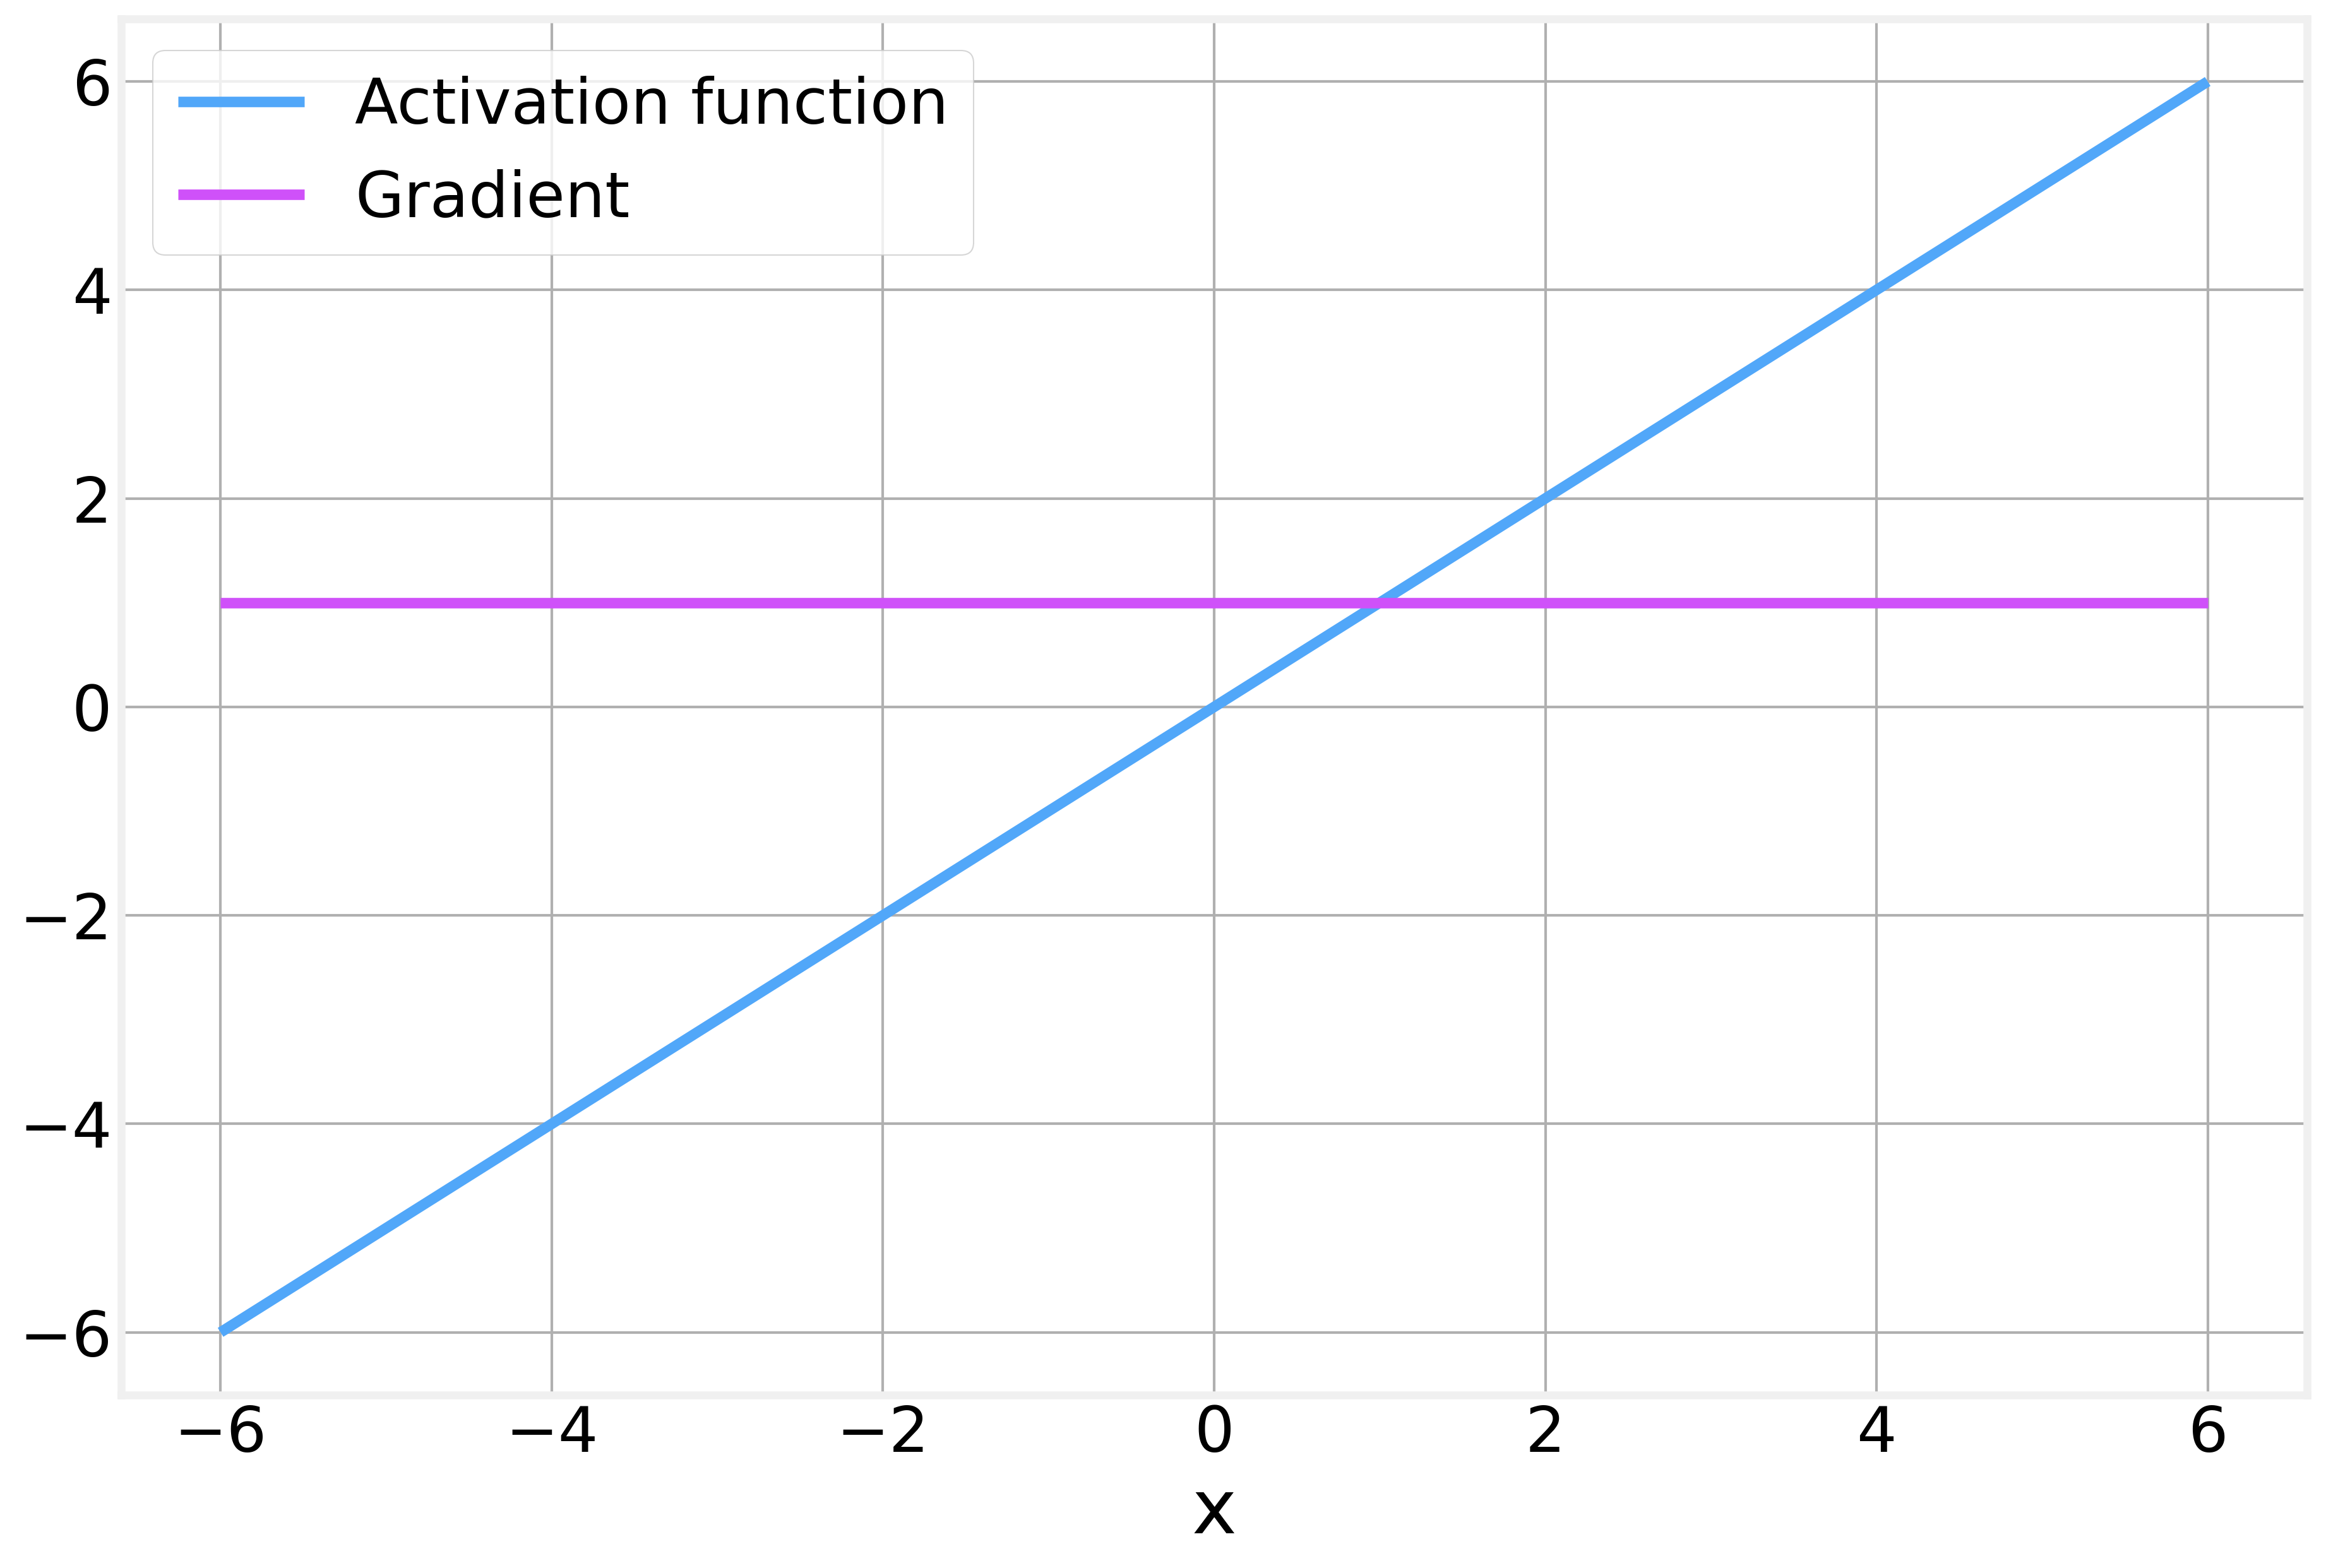

In [5]:
plot_activation_function(torch.nn.Identity())

#### Sigmoid

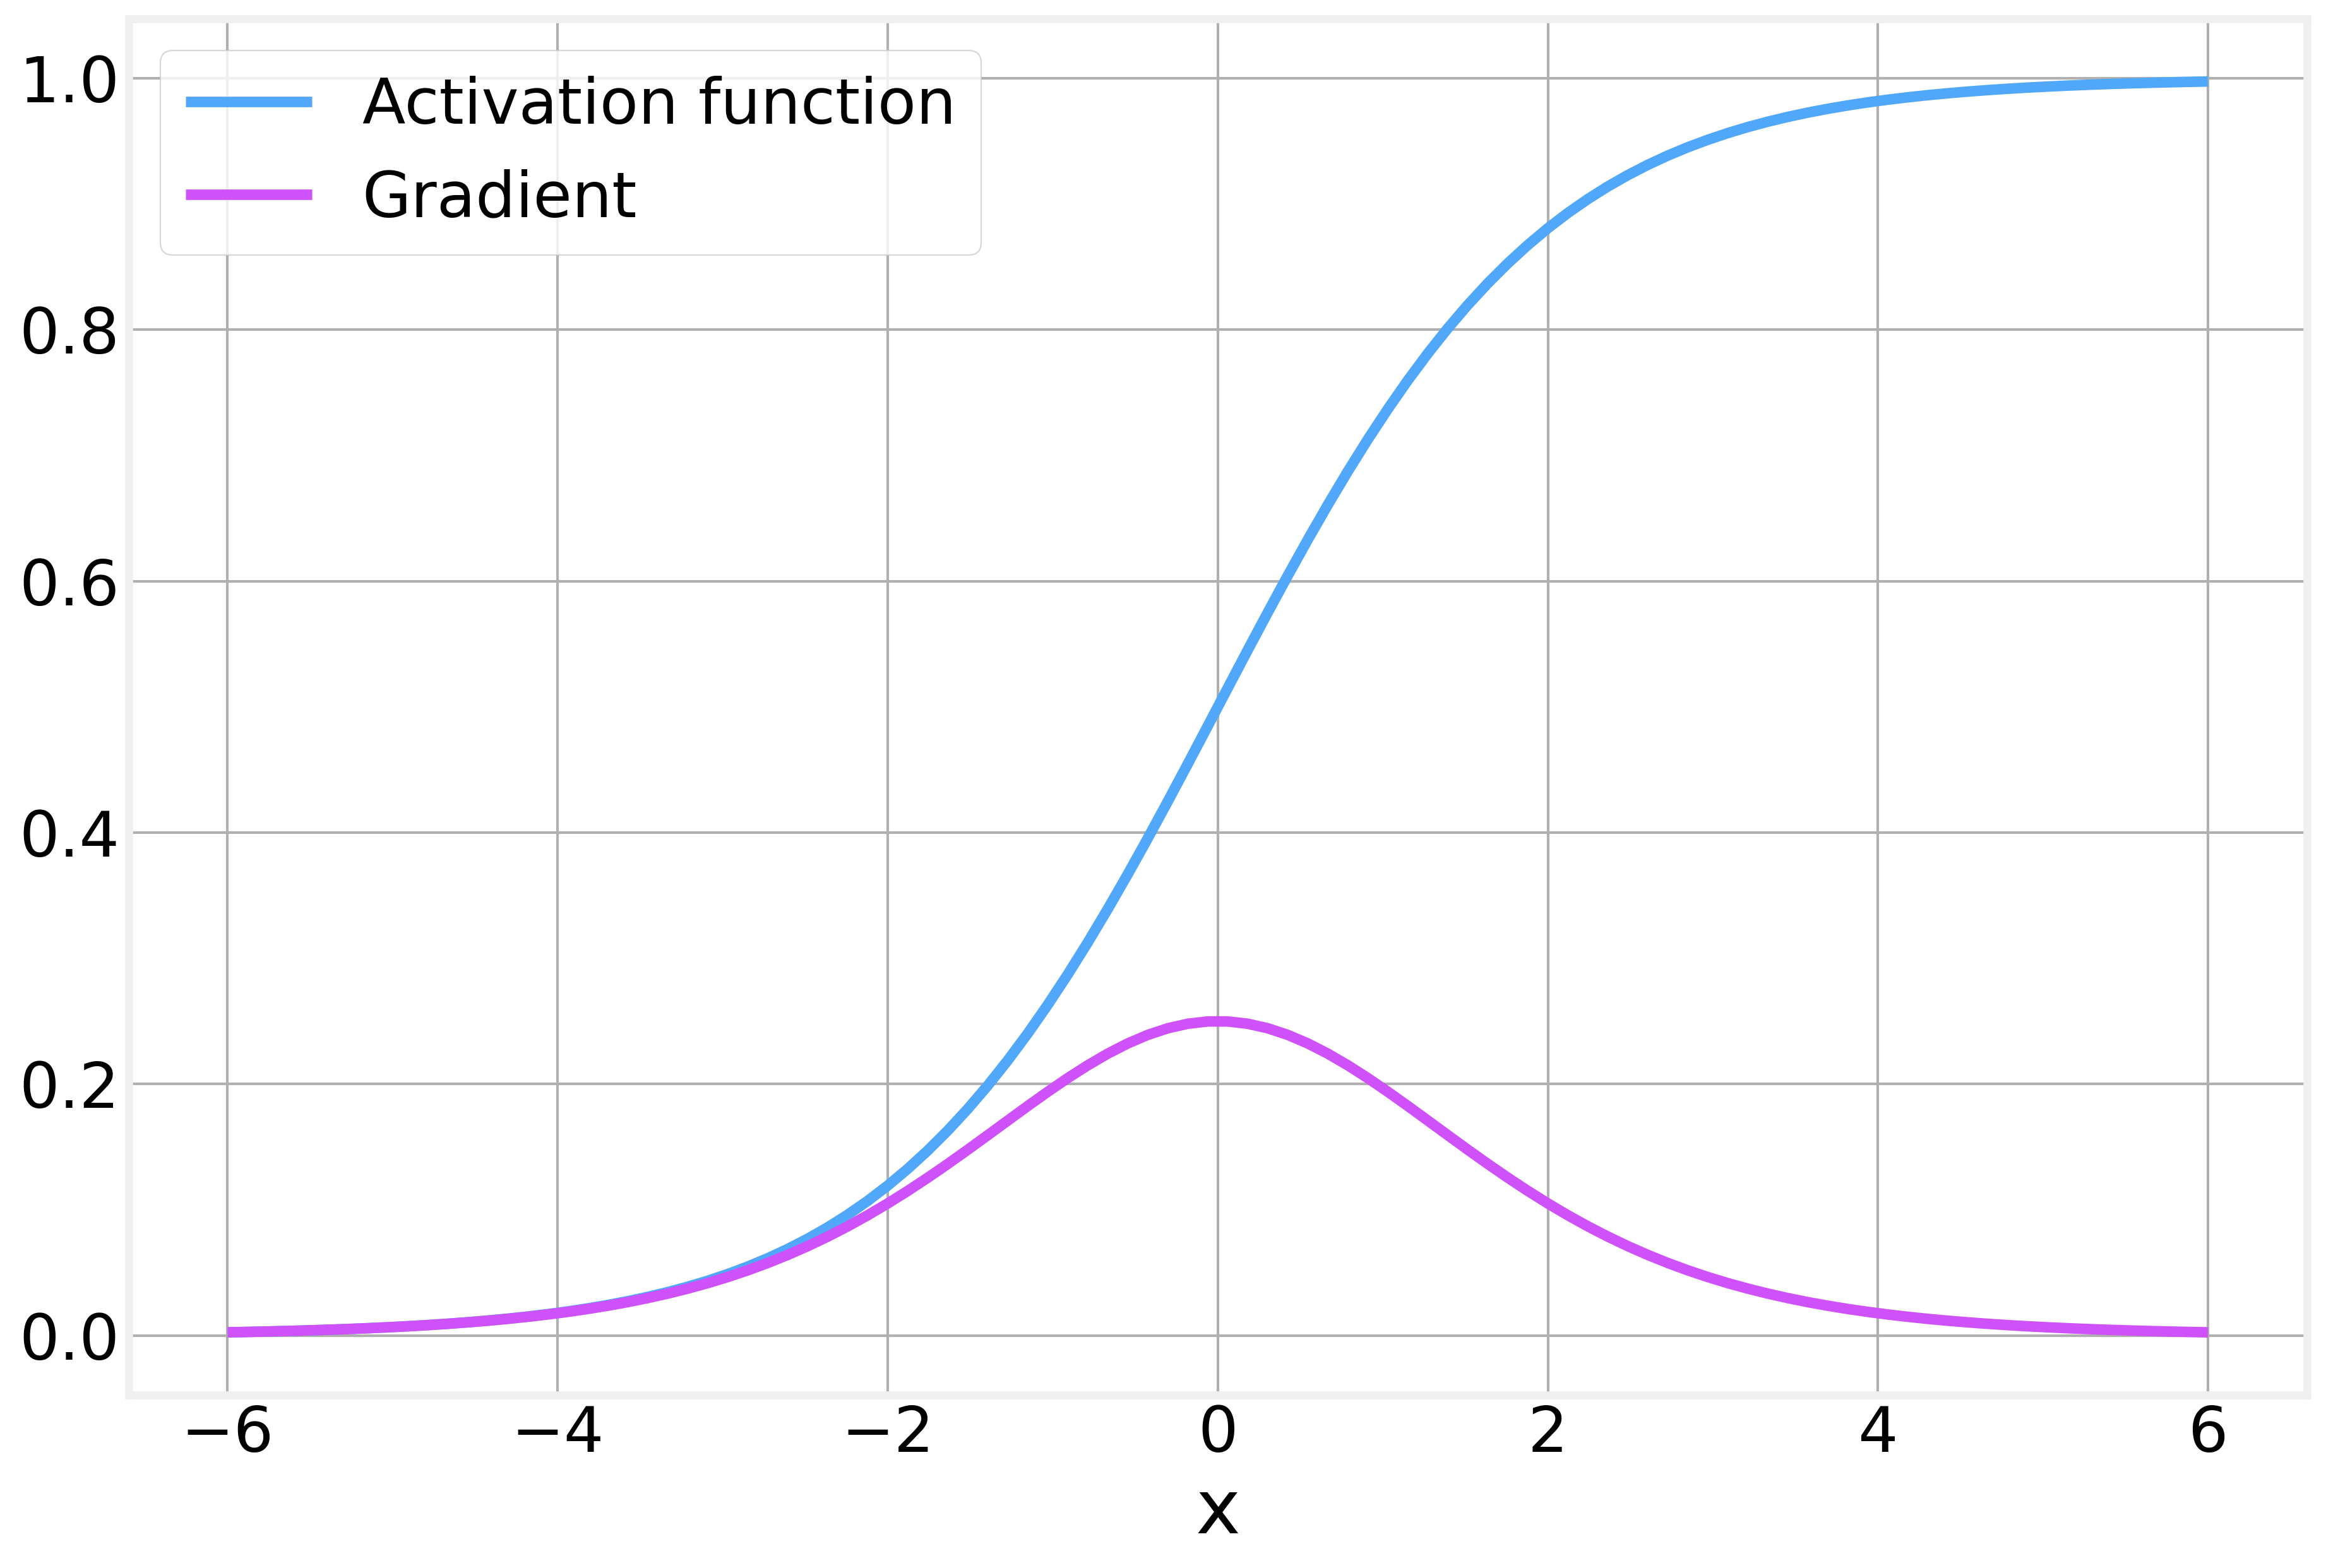

In [6]:
plot_activation_function(torch.sigmoid)

#### Rectified Linear Unit

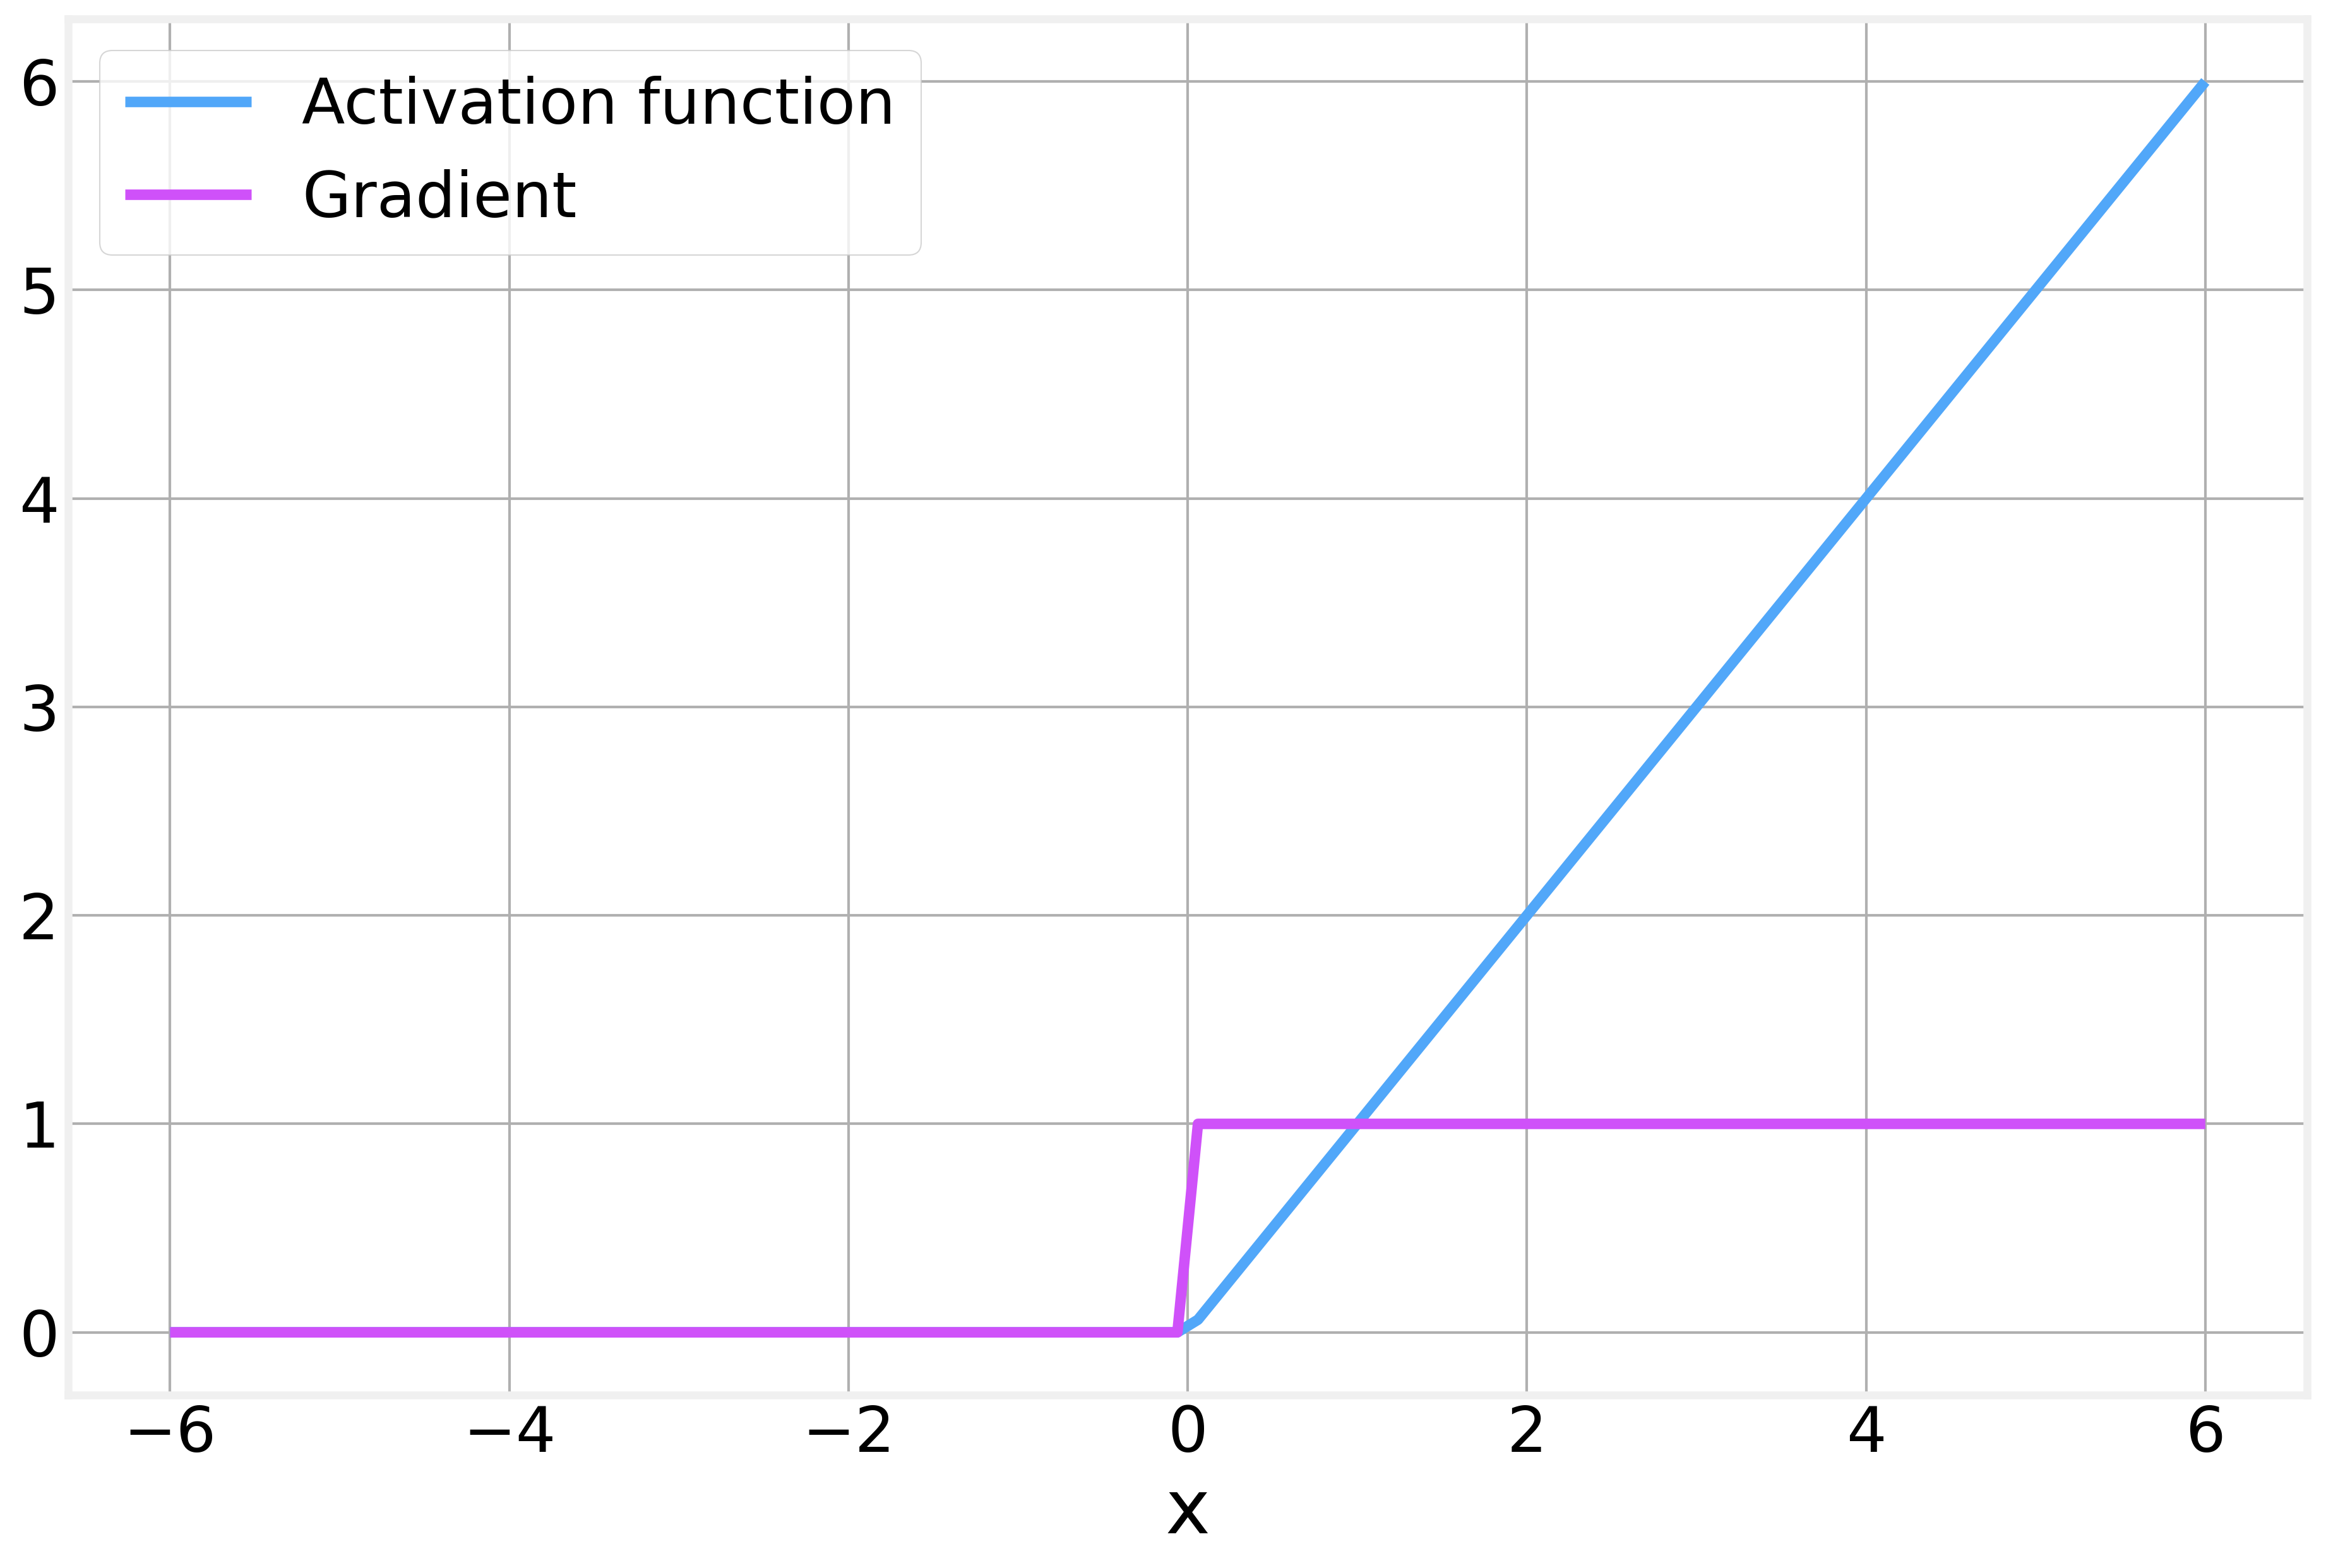

In [7]:
plot_activation_function(torch.relu)

#### Hyperbolic Tangent

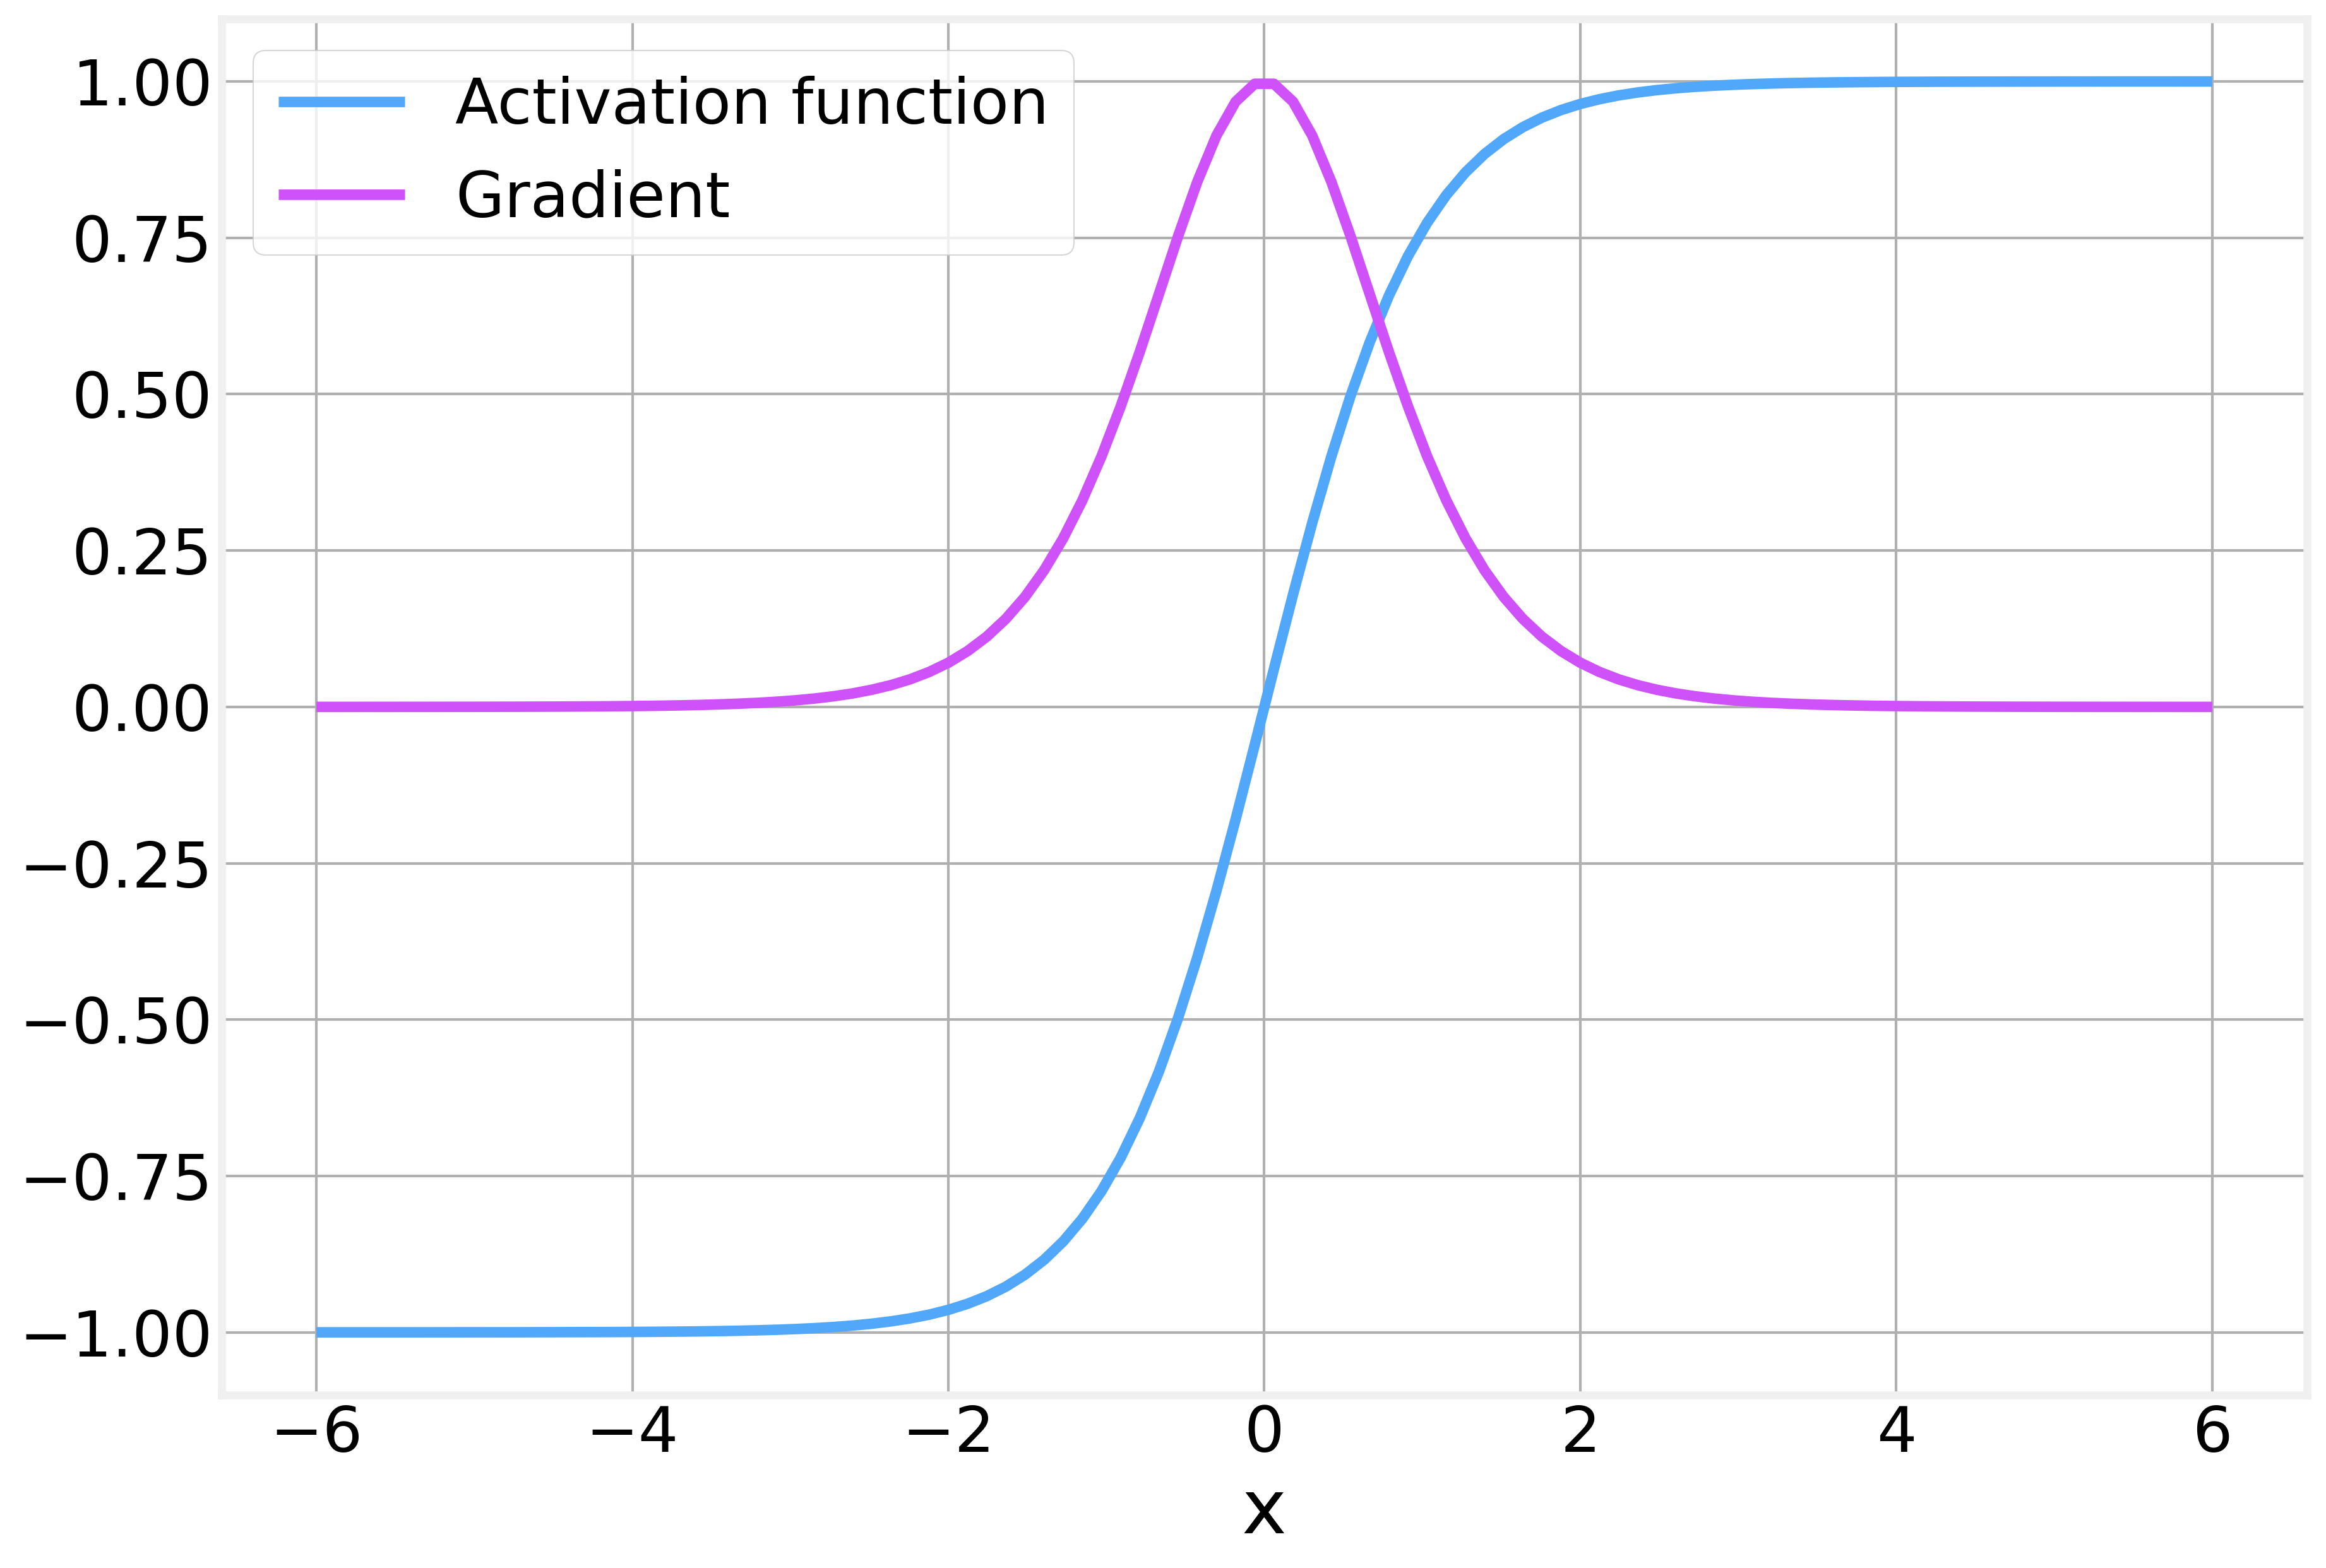

In [8]:
plot_activation_function(torch.tanh)

# Simple Neural Network

We define a simple neural network by creating a new class that inherits form `nn.Module`:

In [9]:
class SimpleNet(nn.Module):
    def __init__(self, n_features):
        super(SimpleNet, self).__init__()
        # Linear regression with one output
        self.linear = nn.Linear(n_features, 1)  

    def forward(self, x):
        x = self.linear(x)
        return x

Next we load our dataset

In [10]:
anscombe = np.loadtxt('data/Anscombe1.dat', delimiter=' ')
anscombe = torch.from_numpy(anscombe).float()

And extract our instances and labels

In [11]:
X = anscombe[:, 0].reshape(-1, 1)
y = anscombe[:, 1].reshape(-1, 1)
n_features = X.shape[1]

In [13]:
X.shape

torch.Size([11, 1])

In [12]:
n_features

1

Now we can instantiate our model

In [14]:
model = SimpleNet(n_features)

Defining the loss function and the optimizer are the next steps

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Training loop

In [16]:
num_epochs = 2_000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Extract model parameters

In [17]:
trained_params = model.state_dict()
print(trained_params)

OrderedDict([('linear.weight', tensor([[0.5308]])), ('linear.bias', tensor([2.6933]))])


And predictions

In [18]:
y_ = outputs.detach().numpy()

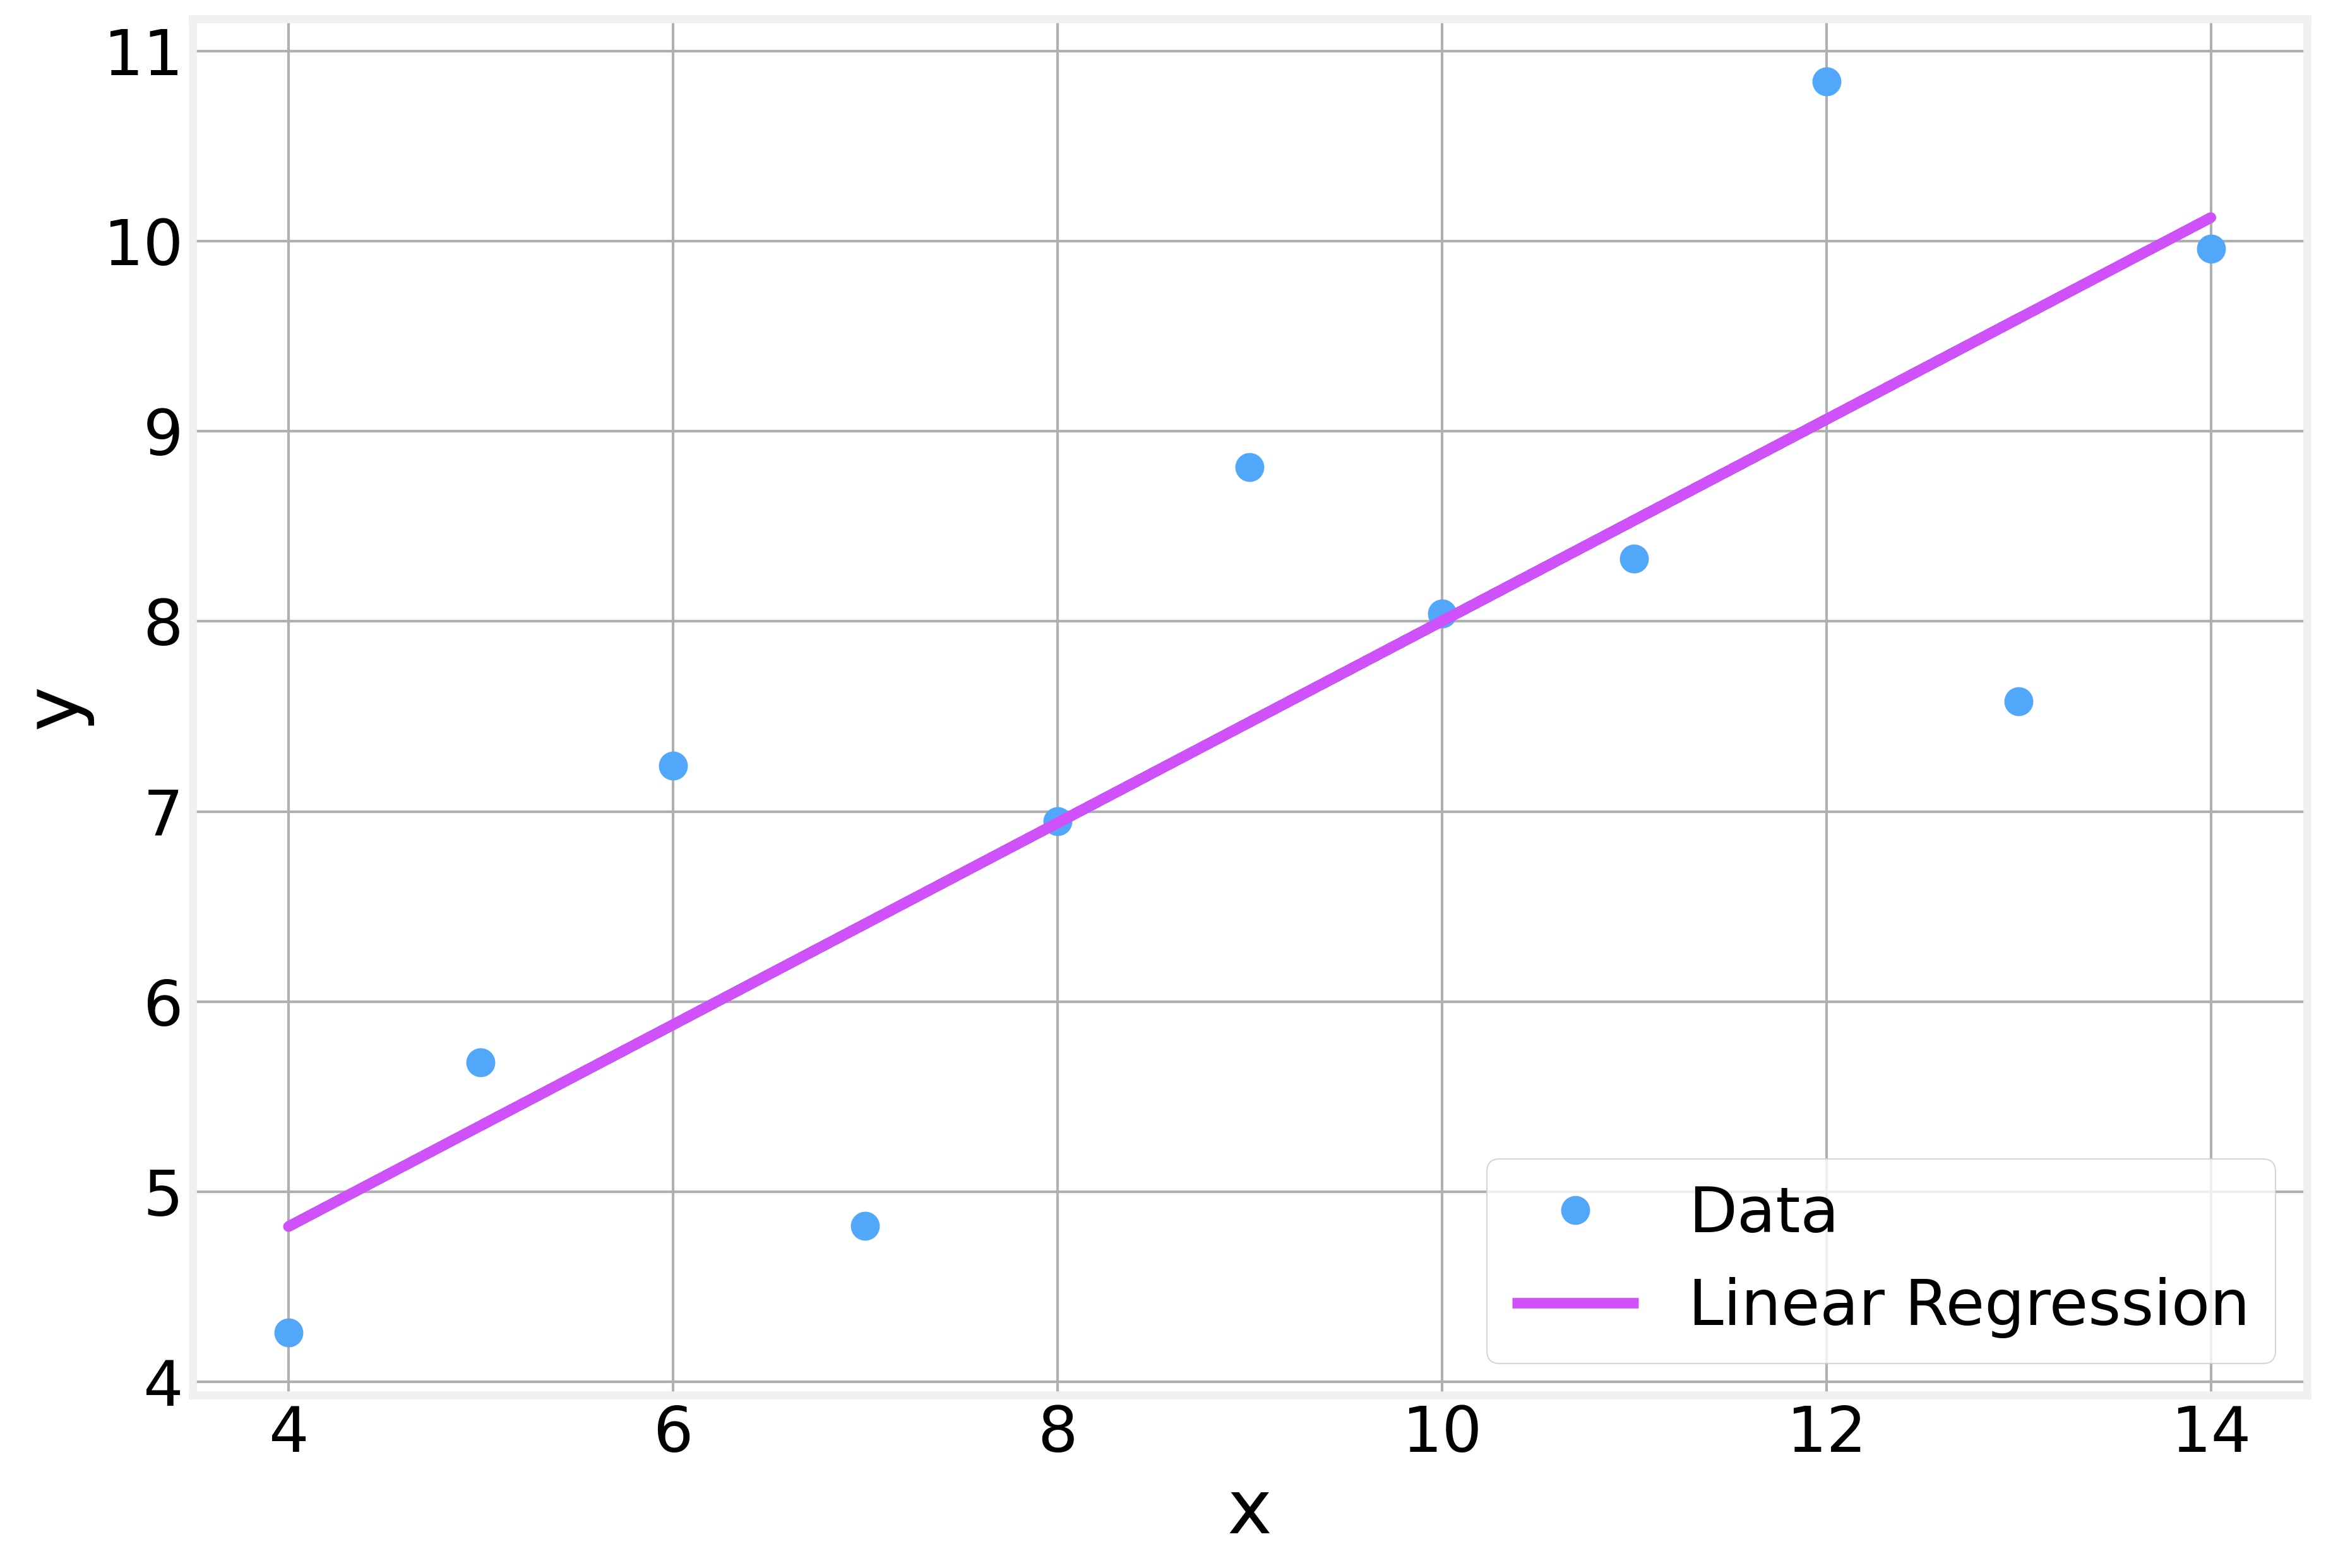

In [19]:
fig, ax = plt.subplots(1)
ax.plot(X, y, 
        marker='o', 
        markersize=10, 
        linestyle='None', 
        label='Data')

ax.plot(X, y_,
        linestyle='-', 
        label='Linear Regression')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower right')

# Neural Network Classifier

Load the MNIST dataset

In [20]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# This will download the data the first time you run it and store it in the `data` folder
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Each data set is an array of tuples. The first element of the tuple is the image itself:

In [21]:
instance = 3
train_dataset[instance][0].shape

torch.Size([1, 28, 28])

Which we can plot easily

(-0.5, 27.5, 27.5, -0.5)

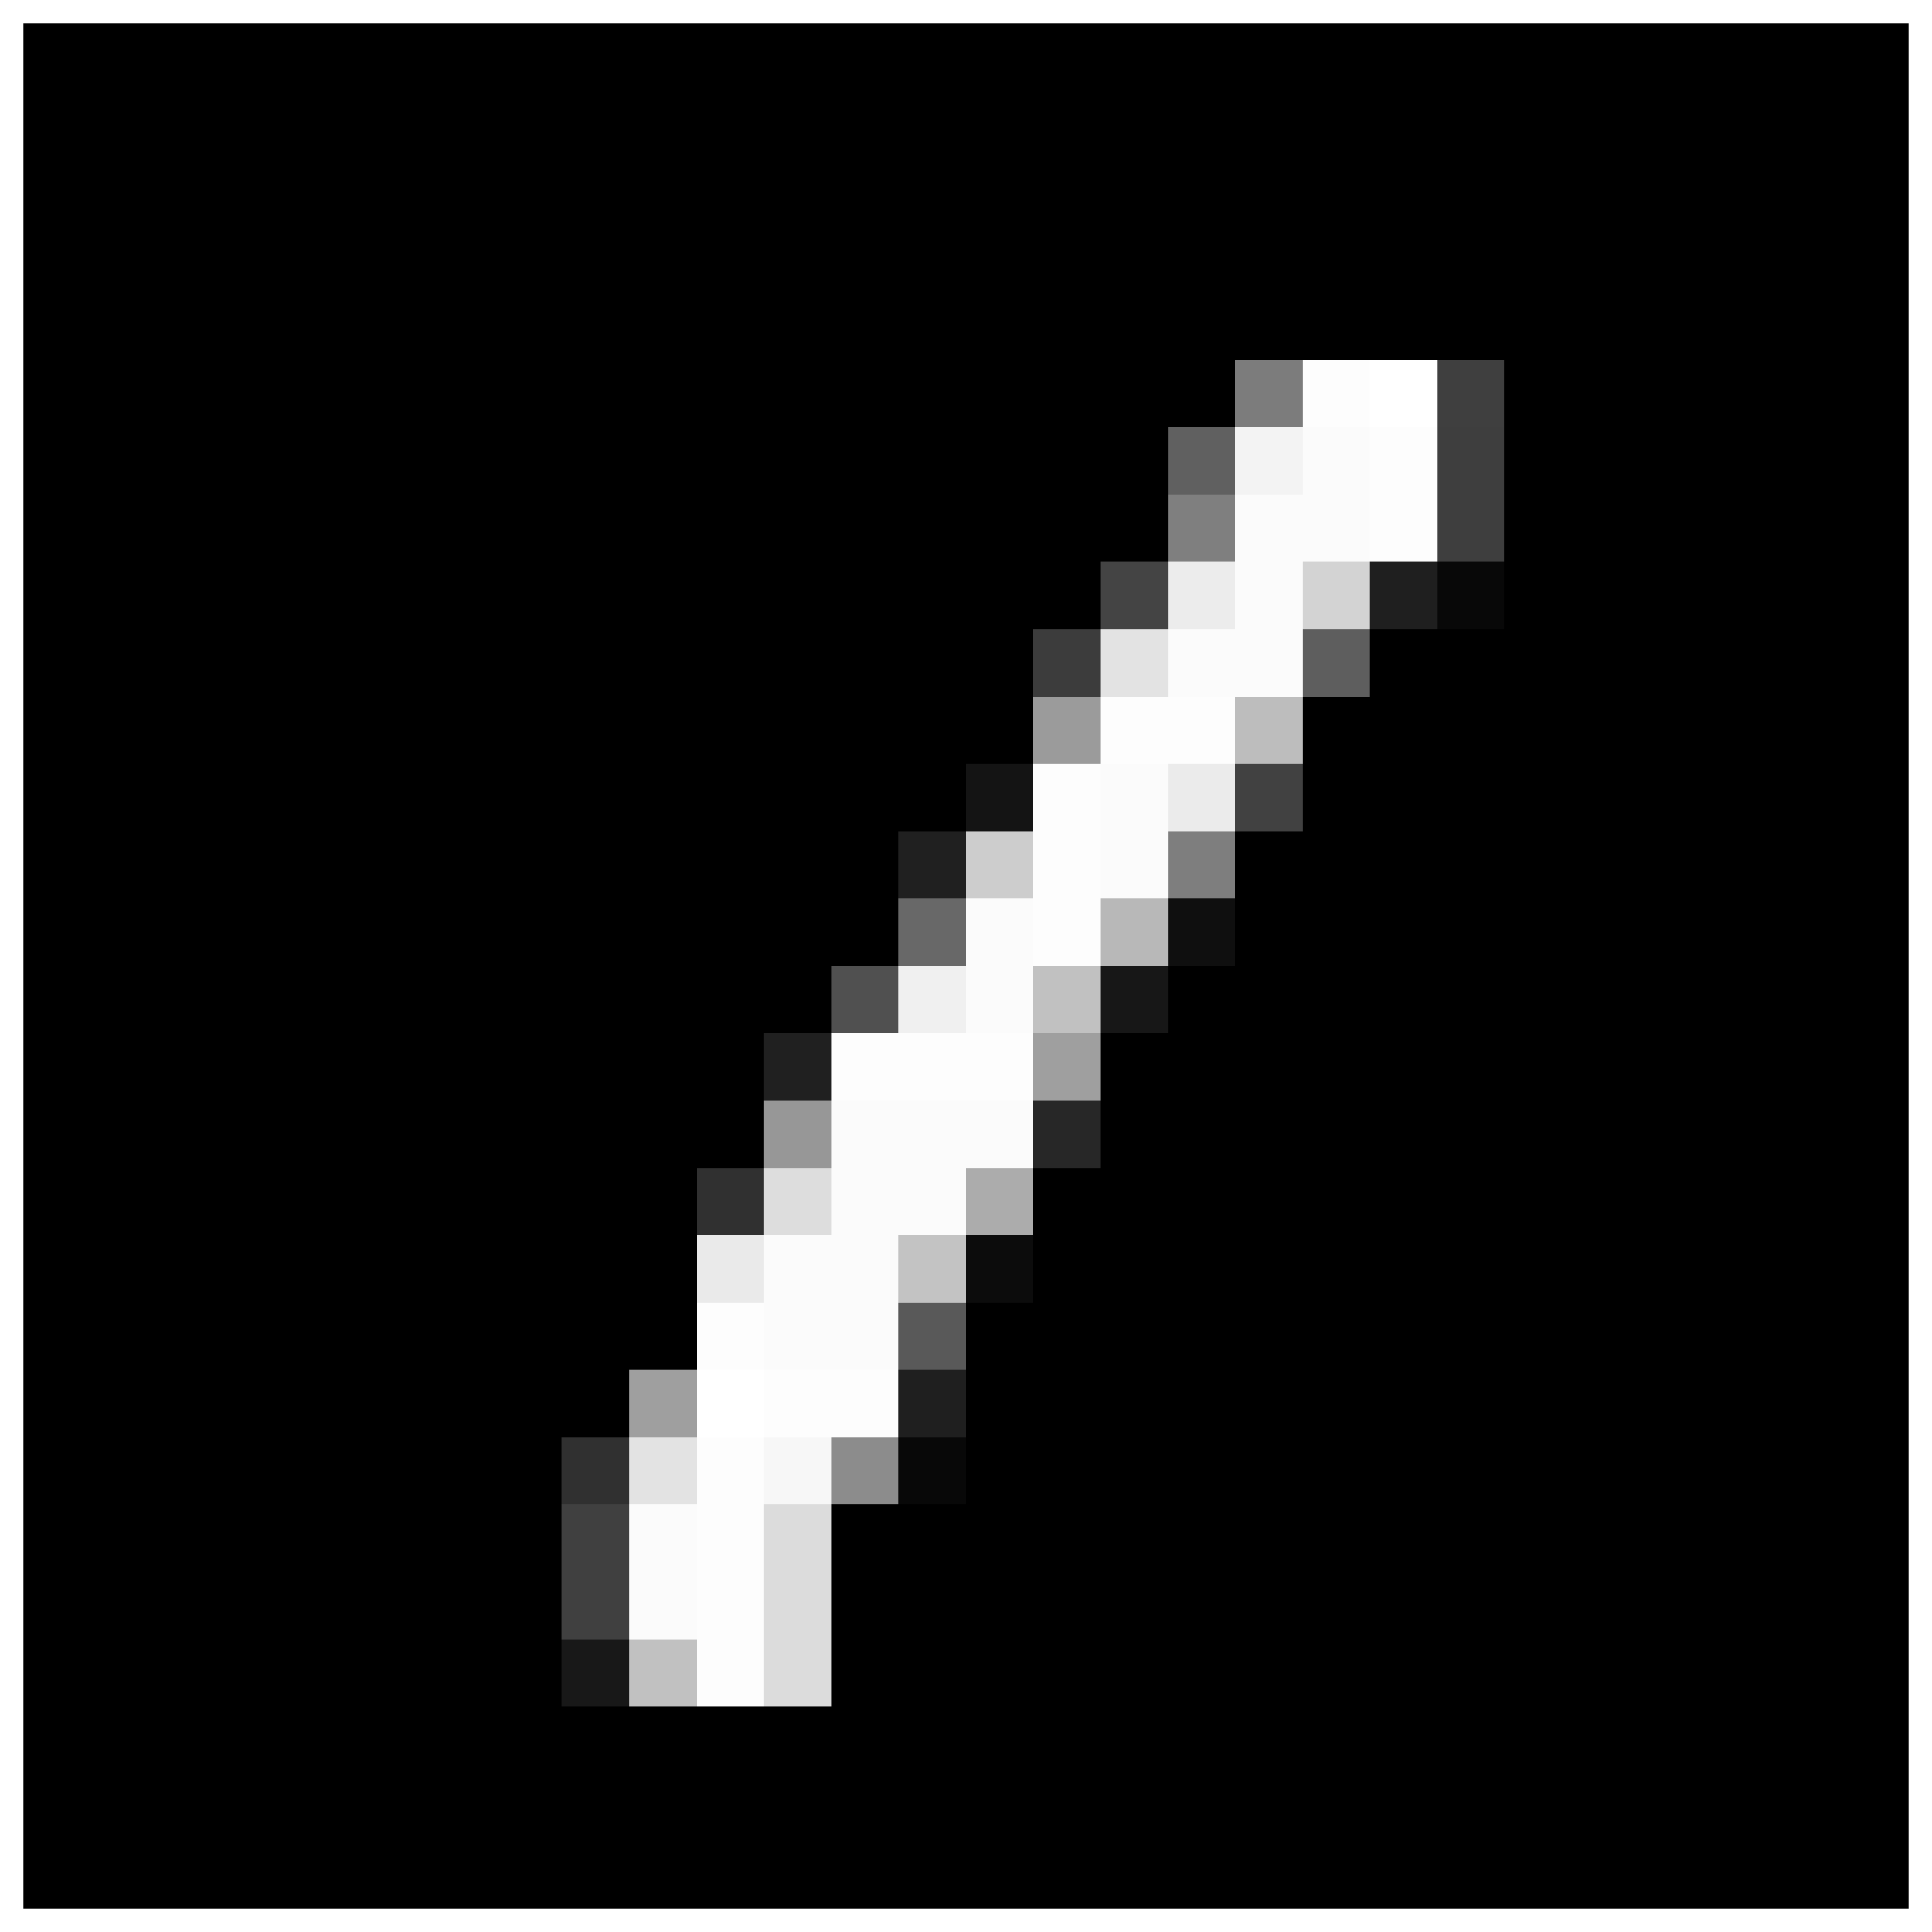

In [22]:
fig, ax = plt.subplots(1)
ax.imshow(train_dataset[instance][0].squeeze(), cmap='gray')
ax.axis('off')

The second element is the label

In [23]:
print(f"This is a picture of the number: {train_dataset[instance][1]}")

This is a picture of the number: 1


We have examples of all digits

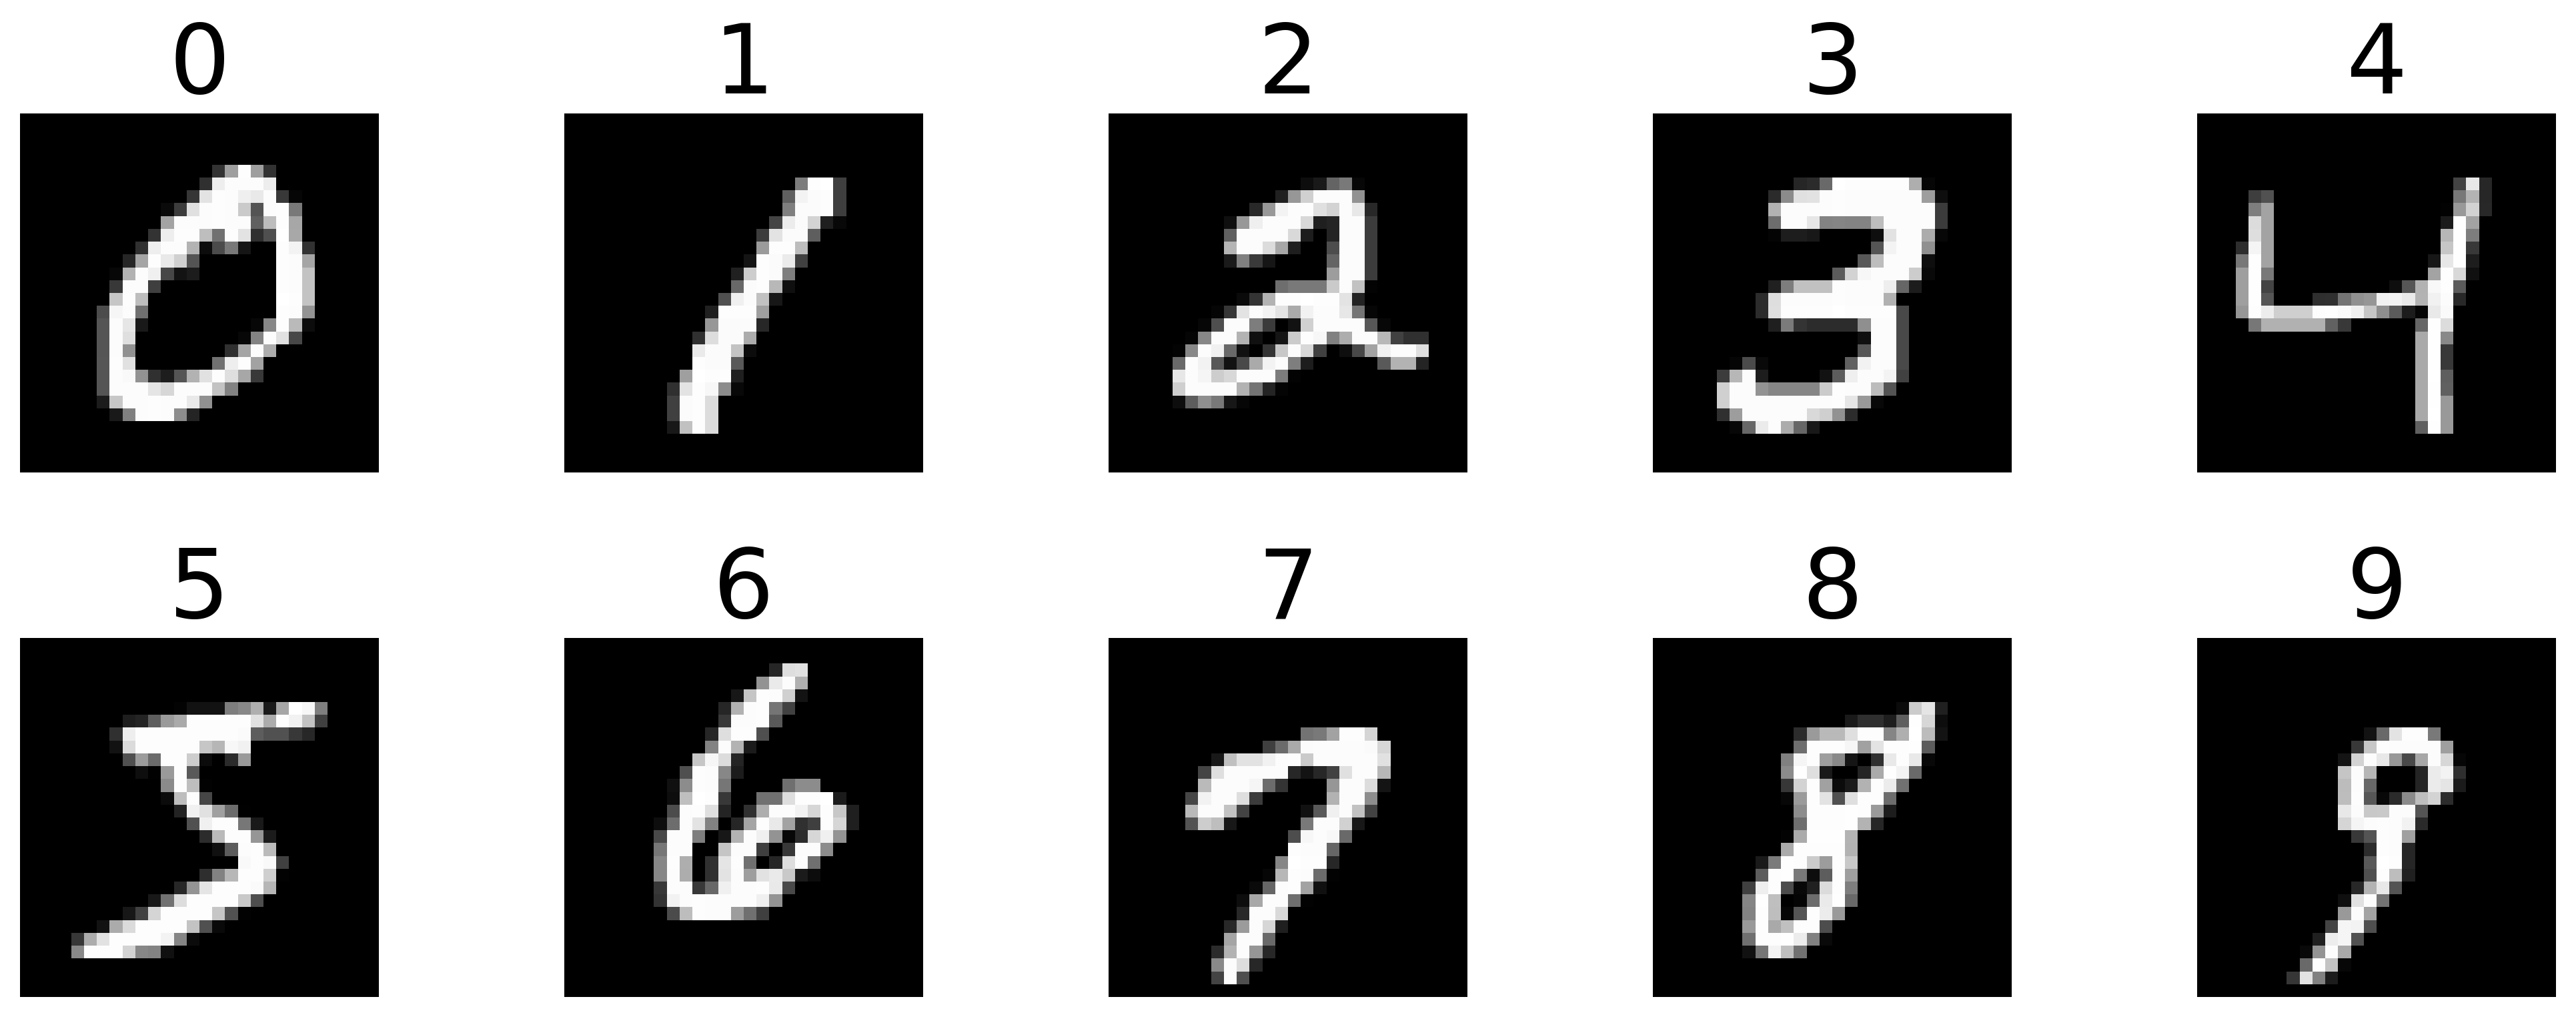

In [24]:
fig, axs_lst = plt.subplots(2, 5, figsize=(14, 5.6))
axs_lst = np.array(axs_lst).flatten()

instances = [1, 3, 5, 7, 2, 0, 13, 15, 17, 19]

for i, instance in enumerate(instances):
    axs_lst[i].imshow(train_dataset[instance][0].squeeze(), cmap='gray')
    axs_lst[i].set_title(train_dataset[instance][1])
    axs_lst[i].axis('off')

fig.tight_layout()

In [25]:
hist_train = Counter([train_dataset[i][1] for i in range(len(train_dataset))])
hist_train = pd.DataFrame.from_dict(hist_train.items())
hist_train.columns = ['Number', 'Frequency']

hist_test = Counter([test_dataset[i][1] for i in range(len(test_dataset))])
hist_test = pd.DataFrame.from_dict(hist_test.items())
hist_test.columns = ['Number', 'Frequency']

/var/folders/lr/j1bs1q851k15cj5y777nxwph0000gn/T/ipykernel_85352/4174146417.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(label):,}' for label in ax.get_yticks()])


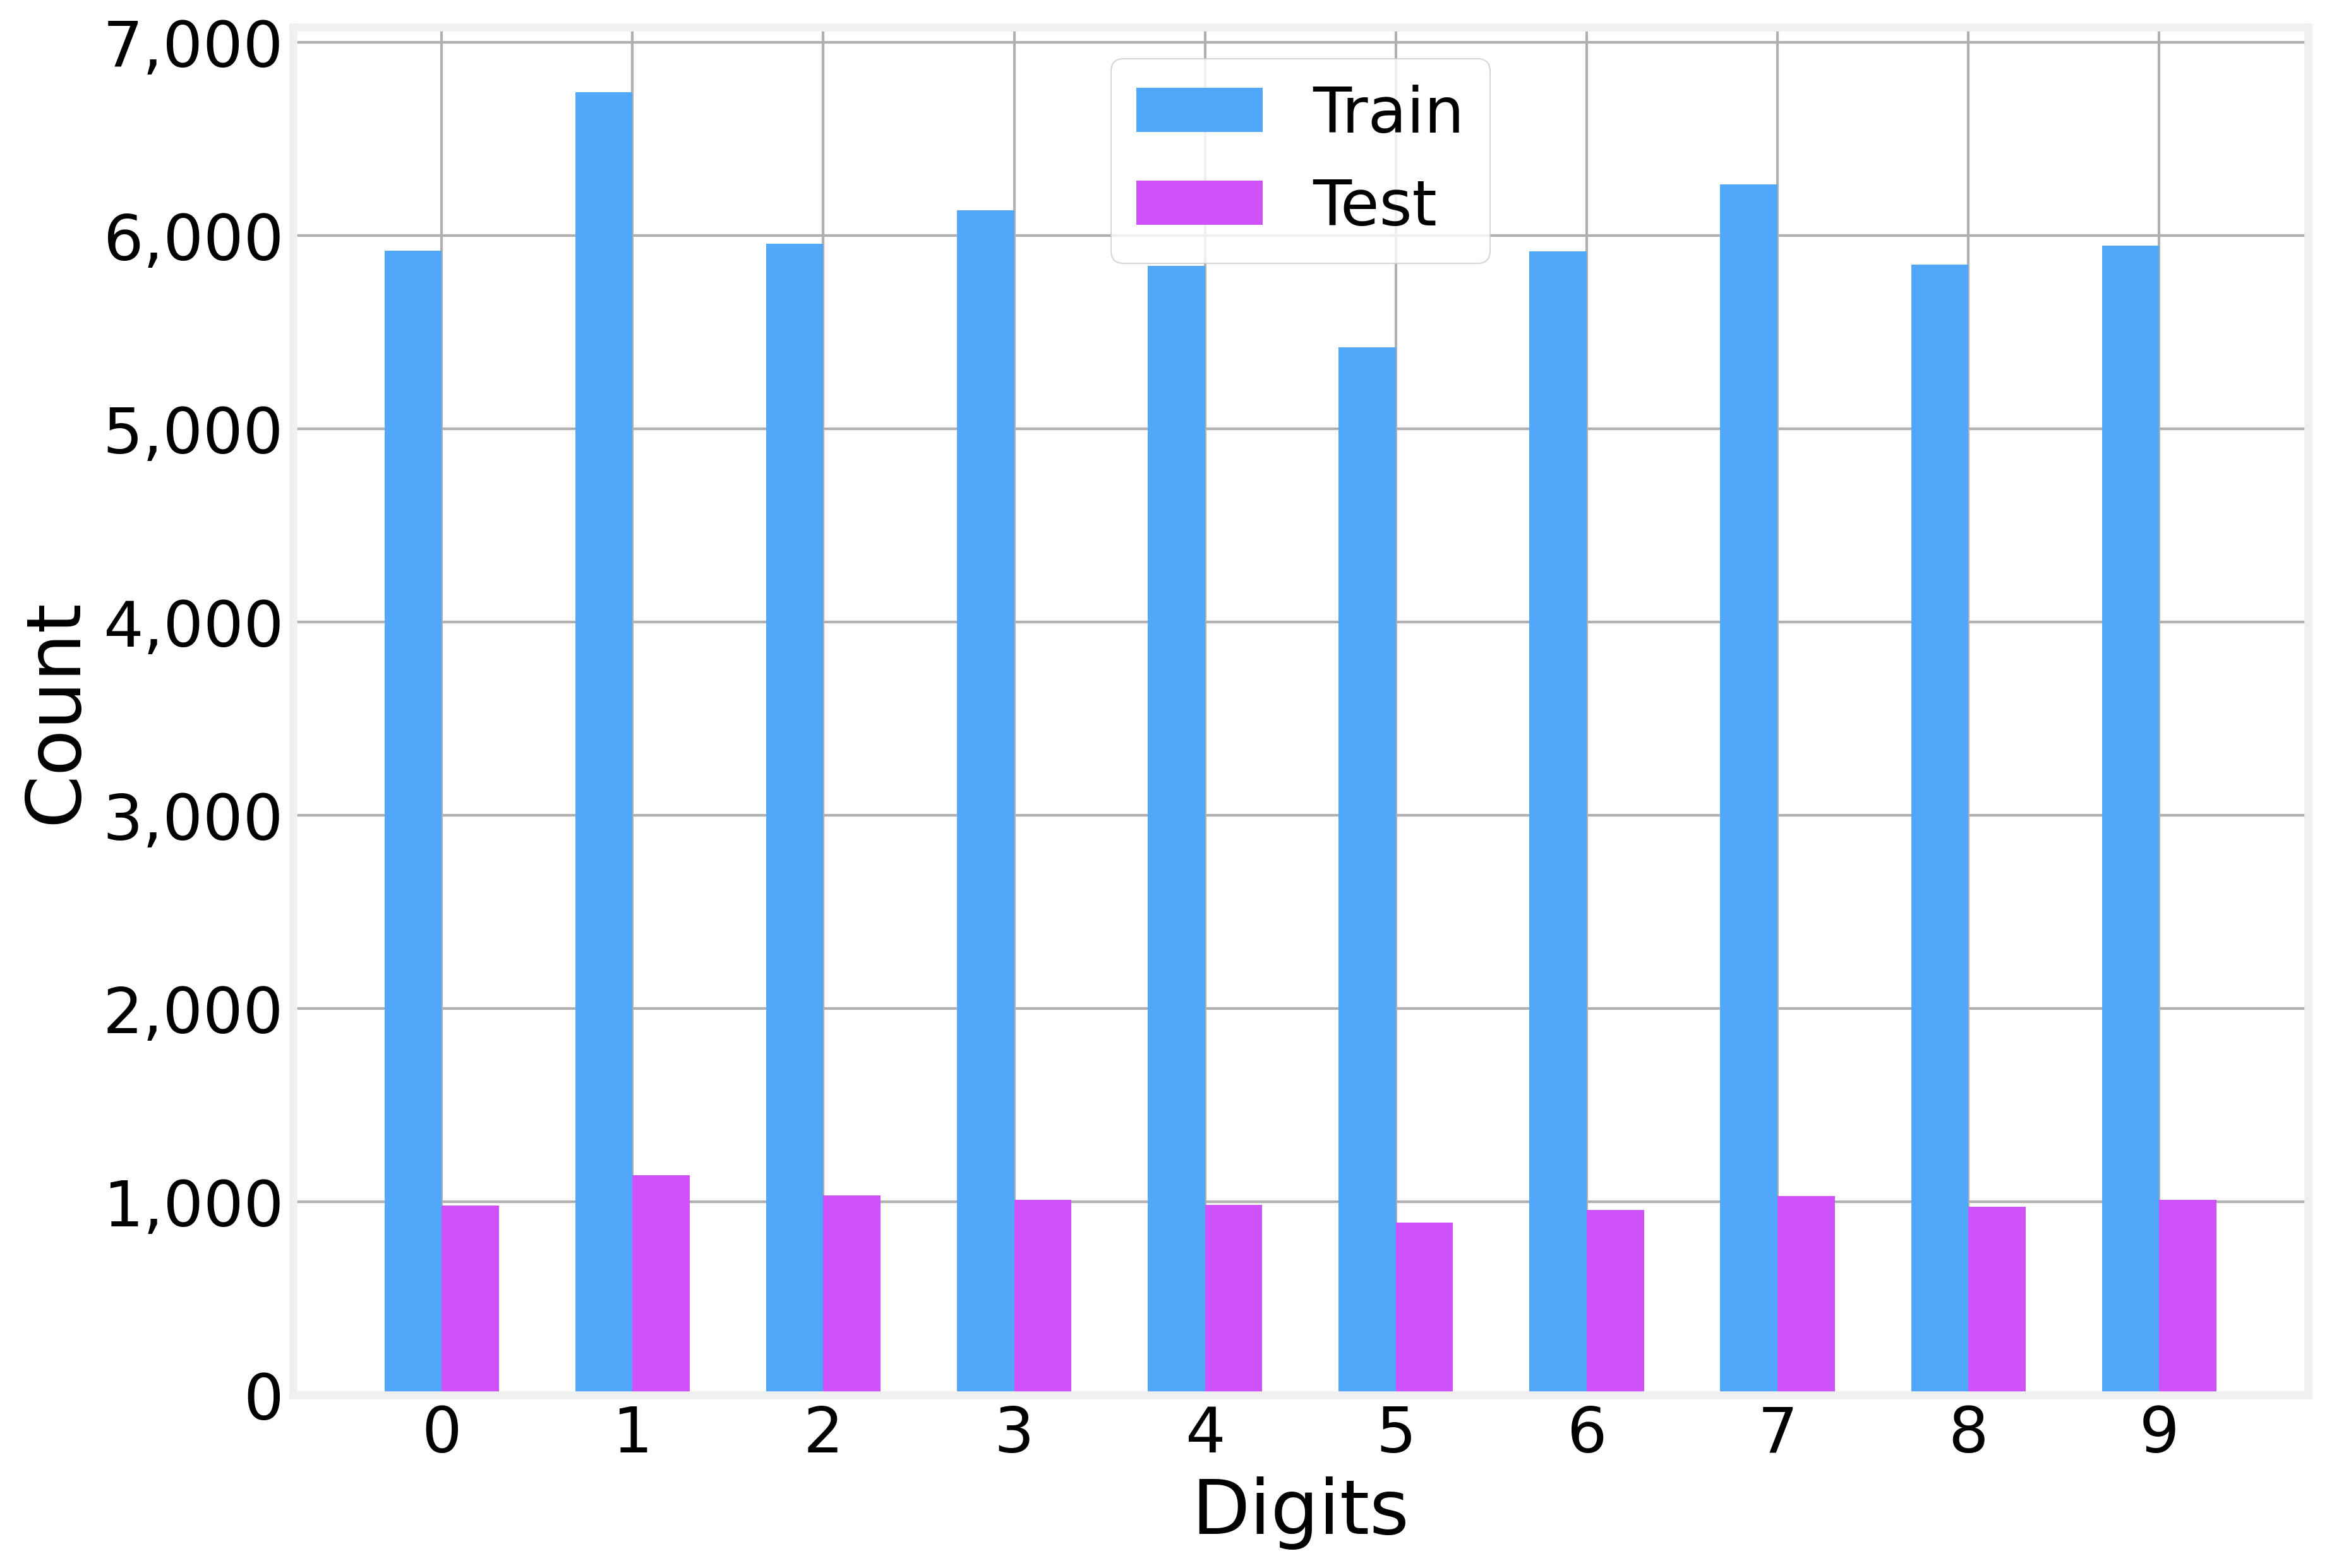

In [26]:
fig, ax = plt.subplots(1)
ax.bar(hist_train['Number']-0.15, hist_train['Frequency'], width=0.3)
ax.bar(hist_test['Number']+0.15, hist_test['Frequency'], width=0.3)
ax.set_xlabel('Digits')
ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
ax.set_ylabel('Count')
ax.set_yticklabels([f'{int(label):,}' for label in ax.get_yticks()])
ax.legend(['Train', 'Test'])

Define the network architecture

In [27]:
class MNISTClassifier1(nn.Module):
    def __init__(self):
        super(MNISTClassifier1, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x0 = x.view(-1, 28*28)  # Flatten the input
        x1 = torch.relu(self.fc1(x0))
        x2 = torch.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        
        return x3

Define the neural network architecture using `nn.Sequential`

In [28]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)

        # Build the model
        self.network = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = self.network(x)
        return x

In [29]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [30]:
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [31]:
# Training loop
num_epochs = 20
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(num_epochs):
    model.train()
    
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()

    with torch.no_grad():
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    history['train_loss'].append(loss.item())
    history['train_acc'].append(100 * train_correct / train_total)
    history['test_acc'].append(100 * test_correct / test_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}  Training Accuracy: {100 * train_correct / train_total:.2f}% Testing Accuracy: {100 * test_correct / test_total:.2f}%')

Epoch [1/20], Loss: 1.5816  Training Accuracy: 91.48% Testing Accuracy: 91.53%
Epoch [2/20], Loss: 1.5309  Training Accuracy: 94.02% Testing Accuracy: 94.20%
Epoch [3/20], Loss: 1.4973  Training Accuracy: 95.01% Testing Accuracy: 94.83%
Epoch [4/20], Loss: 1.5024  Training Accuracy: 96.28% Testing Accuracy: 95.68%
Epoch [5/20], Loss: 1.4849  Training Accuracy: 96.33% Testing Accuracy: 95.93%
Epoch [6/20], Loss: 1.4876  Training Accuracy: 96.77% Testing Accuracy: 96.43%
Epoch [7/20], Loss: 1.4928  Training Accuracy: 96.67% Testing Accuracy: 96.21%
Epoch [8/20], Loss: 1.4828  Training Accuracy: 96.51% Testing Accuracy: 96.02%
Epoch [9/20], Loss: 1.4986  Training Accuracy: 97.19% Testing Accuracy: 96.63%
Epoch [10/20], Loss: 1.4795  Training Accuracy: 97.06% Testing Accuracy: 96.70%
Epoch [11/20], Loss: 1.4862  Training Accuracy: 97.84% Testing Accuracy: 96.94%
Epoch [12/20], Loss: 1.4776  Training Accuracy: 97.63% Testing Accuracy: 97.00%
Epoch [13/20], Loss: 1.4665  Training Accuracy: 9

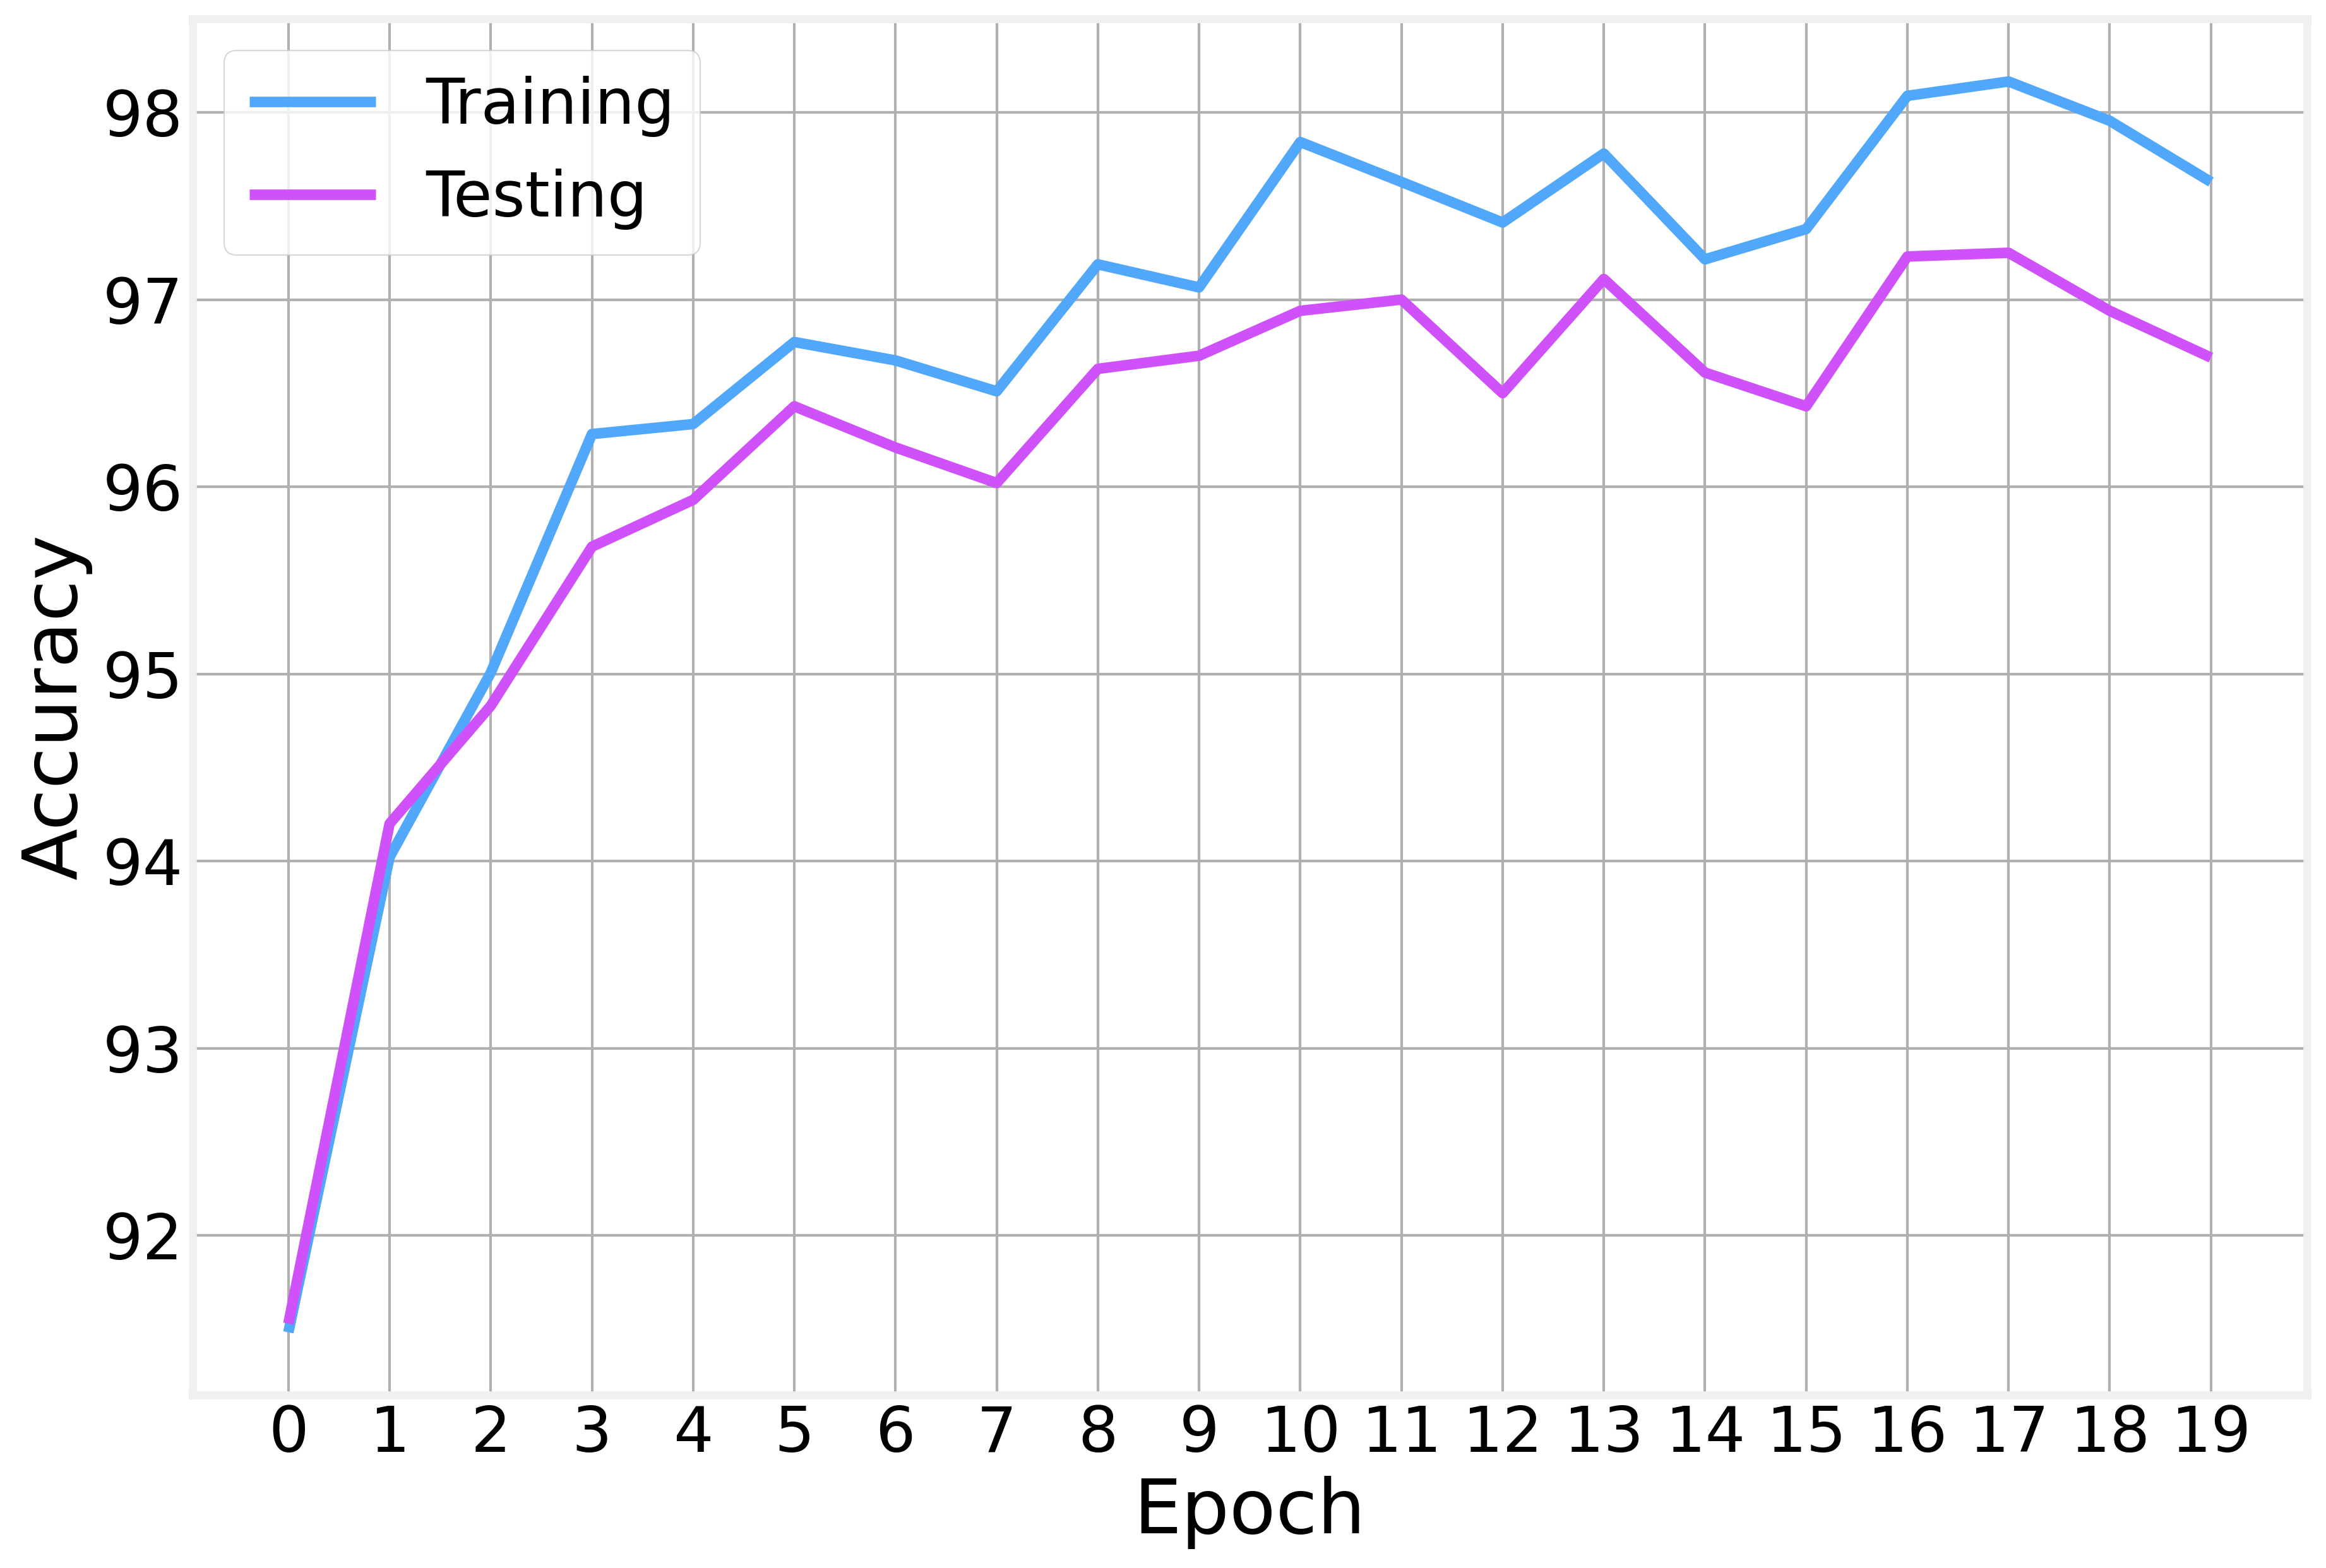

In [32]:
fig, ax = plt.subplots(1)
ax.plot(history['train_acc'], label='Training')
ax.plot(history['test_acc'], label='Testing')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_xticks(range(num_epochs));

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" border="0" width=300px> 
</center>